In [47]:
from io import open
import conllu

with open("../milestone 1/dev_sexism_dataset_conllu.conllu", encoding='ISO-8859-1') as f:
    data = conllu.parse(f.read())

X = []
y = []

for tokenlist in data:
    y.append(tokenlist.metadata['label_sexist'])
    X.append([token['form'] for token in tokenlist])
    

In [42]:
print(X[0])
print(y[0])

['nigeria', ',', 'rape', 'woman', ',', 'men', 'rape', 'back', '!', 'nsfw', '``', 'nigeria', ',', 'rape', 'woman', ',', 'guys', 'rape', 'back', '!', "''"]
not sexist


In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from import_preprocess import ImportPreprocess
from evaluate import Evaluation
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [46]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_dev_test()

X_train, y_train = import_preprocess.X_train, import_preprocess.y_train
X_dev, y_dev = import_preprocess.X_dev, import_preprocess.y_dev
X_test, y_test = import_preprocess.X_test, import_preprocess.y_test

In [47]:
import_preprocess.convert_class_labels()
y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [48]:
def rnn_model(input_length):
    model = Sequential()
    model.add(Embedding(input_dim = input_length, output_dim = 64))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
print(X_train[1])

['like', 'metallica', 'video', 'poor', 'mutilated', 'bastard', 'saying', '``', 'please', 'kill', "''", ',', 'emojis', 'instead', 'morse', 'code', '.']


In [54]:
def run_rnn(X_train, y_train, X_dev, y_dev):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    n = len(tokenizer.word_index) + 1
    
    X_t = tokenizer.texts_to_sequences(X_train)
    X_t = pad_sequences(X_t, maxlen=100)
    
    X_d = tokenizer.texts_to_sequences(X_dev)
    X_d = pad_sequences(X_d, maxlen=100)

    y_t = np.array(y_train)
    y_d = np.array(y_dev)
    
    model = rnn_model(input_length = n)
    model.fit(X_t, y_t, epochs=10, batch_size=32, validation_data=(X_d, y_d))
    
    return model, tokenizer


In [55]:
RNN, tokenizer = run_rnn(X_train, y_train, X_dev, y_dev)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7607 - loss: 0.5437 - val_accuracy: 0.7965 - val_loss: 0.4575
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8344 - loss: 0.3879 - val_accuracy: 0.8165 - val_loss: 0.4208
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8722 - loss: 0.3232 - val_accuracy: 0.8325 - val_loss: 0.4586
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8909 - loss: 0.2826 - val_accuracy: 0.7975 - val_loss: 0.4500
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9029 - loss: 0.2611 - val_accuracy: 0.8300 - val_loss: 0.4716
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9168 - loss: 0.2306 - val_accuracy: 0.8305 - val_loss: 0.4795
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9245 - loss: 0.2100 - val_accuracy: 0.8240 - val_loss: 0.5051
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9394 - loss: 0.1709 - val_accu

In [58]:
def evaluate_rnn(model, tokenizer, X_test, y_test):
    X_test_ = tokenizer.texts_to_sequences(X_test)
    X_test_ = pad_sequences(X_test_, maxlen=100)
    
    y_true = np.array(y_test)
    
    y_pred = model.predict(X_test_)
    y_pred = np.round(y_pred)
    
    evaluation = Evaluation(RNN)
    evaluation.calculate_print_metrics(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["0 - not sexist", "1 - sexist"], yticklabels=["0 - not sexist", "1 - sexist"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return evaluation

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
accuracy: 0.8130
balanced accuracy: 0.7332
precision: 0.6233
recall: 0.5784


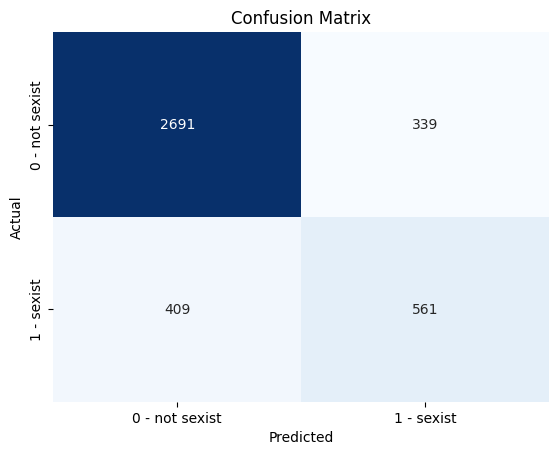

In [59]:
evaluate_rnn(RNN, tokenizer, X_test, y_test)